# Final Evaluation

In [6]:
import os
import sys
from importlib import reload

# Ensure project root is on sys.path so `surgical_phase_tool` is importable
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import surgical_phase_tool.evaluate as eval_module

reload(eval_module)
eval_module.evaluate_model()

Using device: cpu

=== TEST EVALUATION ===
Overall Phase Accuracy: 0.9619
Per-class Phase Accuracy (order of PHASE_TO_ID):
  0 - Preparation: 1.0000
  1 - CalotTriangleDissection: 0.9900
  2 - ClippingCutting: 1.0000
  3 - GallbladderDissection: 1.0000
  4 - CleaningCoagulation: 0.9800
  5 - GallbladderPackaging: 1.0000
  6 - GallbladderRetraction: 0.9600
  7 - Undefined: 0.7812

Confusion Matrix (rows=true, cols=pred):
[[ 98   0   0   0   0   0   0   0]
 [  1  99   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0]
 [  0   0   0   0  98   0   0   2]
 [  0   0   0   0   0  41   0   0]
 [  1   0   0   1   0   1  96   1]
 [  8   1   1   2   4   4   1  75]]

=== TOOL METRICS WITHOUT PHASE MASKING ===
Micro-F1: 0.1959 (P=0.1959, R=0.1959)
  Argonbeamer: P=0.0000, R=0.0000, F1=0.0000
  Clip-Applicator: P=0.2721, R=1.0000, F1=0.4278
  Drainage: P=0.0000, R=0.0000, F1=0.0000
  Grasper: P=0.0000, R=0.0000, F1=0.0000
  HF-Coagulation-Probe: P=0.2721, R=

In [7]:
import os
from surgical_phase_tool.utils.report_utils import get_export_dir, save_figure, save_table

EXPORT_DIR = get_export_dir()
EXPORT_DIR

'/Users/mac/Desktop/AI/surgical_phase_tool/notebooks/exports'

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from surgical_phase_tool.config import (
    TEST_MANIFEST, BATCH_SIZE, NUM_WORKERS, DEVICE, CHECKPOINT_PATH, SEED
)
from surgical_phase_tool.config_loader import set_global_seed
from surgical_phase_tool.dataset import MultiTaskWindowDataset, PHASE_TO_ID, TOOL_COLUMNS, ID_TO_PHASE
from surgical_phase_tool.models.resnet_multitask import PhaseToolNet
from surgical_phase_tool.hierarchy.phase_tool_mask import build_phase_tool_mask, apply_phase_mask_to_logits
from surgical_phase_tool.metrics import phase_metrics, tool_metrics

set_global_seed(SEED)

test_dataset = MultiTaskWindowDataset(TEST_MANIFEST, is_train=False)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False
)

model = PhaseToolNet(backbone_name='resnet18', pretrained=False).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

phase_tool_mask = build_phase_tool_mask().to(DEVICE)

all_phase_logits, all_phase_targets = [], []
all_tool_logits, all_tool_targets = [], []
with torch.no_grad():
    for frames, phase_target, tool_target in test_loader:
        frames = frames.to(DEVICE)
        phase_target = phase_target.to(DEVICE)
        tool_target = tool_target.to(DEVICE)
        phase_logits, tool_logits = model(frames)
        all_phase_logits.append(phase_logits.cpu())
        all_phase_targets.append(phase_target.cpu())
        all_tool_logits.append(tool_logits.cpu())
        all_tool_targets.append(tool_target.cpu())

all_phase_logits = torch.cat(all_phase_logits, dim=0)
all_phase_targets = torch.cat(all_phase_targets, dim=0)
all_tool_logits = torch.cat(all_tool_logits, dim=0)
all_tool_targets = torch.cat(all_tool_targets, dim=0)

phase_overall_acc, phase_per_class_acc, cm = phase_metrics(all_phase_logits, all_phase_targets)
tool_stats_no_mask = tool_metrics(all_tool_logits, all_tool_targets, threshold=0.5)
phase_probs = all_phase_logits.softmax(dim=-1)
masked_logits = apply_phase_mask_to_logits(all_tool_logits, phase_probs, phase_tool_mask.to(all_tool_logits.device), hard=False)
tool_stats_with_mask = tool_metrics(masked_logits, all_tool_targets, threshold=0.5)

phase_overall_acc, tool_stats_no_mask['f1_micro'], tool_stats_with_mask['f1_micro']

(np.float64(0.9619047619047619), 0.19591836734693877, 0.9698206555349412)

Overall phase accuracy: 0.9619047619047619

Per-class phase accuracy:
0 - Preparation: 1.0000
1 - CalotTriangleDissection: 0.9900
2 - ClippingCutting: 1.0000
3 - GallbladderDissection: 1.0000
4 - CleaningCoagulation: 0.9800
5 - GallbladderPackaging: 1.0000
6 - GallbladderRetraction: 0.9600
7 - Undefined: 0.7812


,accuracy
phase,
Preparation,1.00000
CalotTriangleDissection,0.99000
ClippingCutting,1.00000
GallbladderDissection,1.00000
CleaningCoagulation,0.98000
GallbladderPackaging,1.00000
GallbladderRetraction,0.96000
Undefined,0.78125


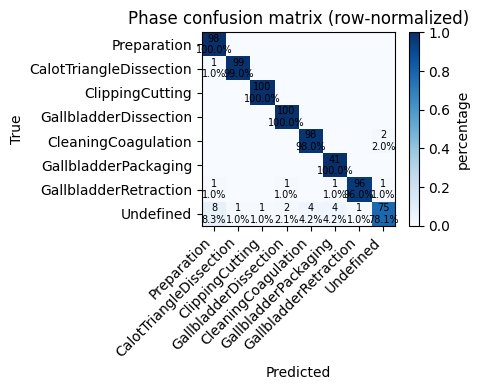

In [9]:
phases = list(PHASE_TO_ID.keys())
print('Overall phase accuracy:', phase_overall_acc)
print()
print('Per-class phase accuracy:')
for p, idx in PHASE_TO_ID.items():
    print(f'{idx} - {p}: {phase_per_class_acc[idx]:.4f}')

phase_acc_df = pd.DataFrame({
    'phase': phases,
    'accuracy': [phase_per_class_acc[PHASE_TO_ID[p]] for p in phases],
}).set_index('phase')
display(phase_acc_df)
save_table(phase_acc_df, 'phase_accuracy_per_class.csv', EXPORT_DIR)

cm_norm = cm.astype(float)
row_sums = cm_norm.sum(axis=1, keepdims=True).clip(min=1.0)
cm_norm /= row_sums

plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
plt.title('Phase confusion matrix (row-normalized)')
plt.colorbar(label='percentage')
tick_marks = np.arange(len(phases))
plt.xticks(tick_marks, phases, rotation=45, ha='right')
plt.yticks(tick_marks, phases)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(len(phases)):
    for j in range(len(phases)):
        count = int(cm[i, j])
        pct = 100.0 * cm_norm[i, j]
        if count > 0 or pct > 0:
            text = f'{count}\n{pct:.1f}%'
            plt.text(j, i, text, ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
save_figure('phase_confusion_matrix.png', EXPORT_DIR)
plt.show()

Tool micro-F1 without hierarchy: 0.19591836734693877
Tool micro-F1 with hierarchy   : 0.9698206555349412



,precision_no_mask,recall_no_mask,f1_no_mask,precision_with_mask,recall_with_mask,f1_with_mask,delta_f1
tool,,,,,,,
Argonbeamer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Clip-Applicator,0.272109,1.000000,0.427807,1.000000,0.770000,0.870056,0.442249
Drainage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Grasper,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HF-Coagulation-Probe,0.272109,1.000000,0.427807,1.000000,0.815000,0.898072,0.470264
Needle-Probe,0.055782,1.000000,0.105670,0.975610,0.975610,0.975610,0.869940
Palpation-Probe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PE-Forceps,0.698234,0.990888,0.819209,0.995227,0.949886,0.972028,0.152819
Scissor,0.408163,1.000000,0.579710,1.000000,0.806667,0.892989,0.313279


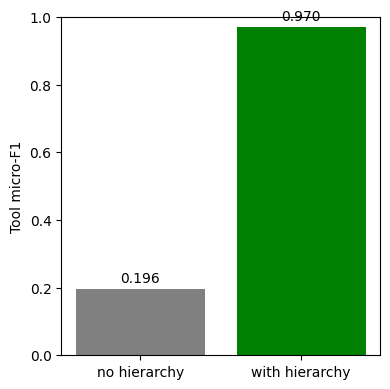

In [10]:
print('Tool micro-F1 without hierarchy:', tool_stats_no_mask['f1_micro'])
print('Tool micro-F1 with hierarchy   :', tool_stats_with_mask['f1_micro'])
print()

tool_summary = pd.DataFrame({
    'tool': TOOL_COLUMNS,
    'precision_no_mask': tool_stats_no_mask['precision_per'],
    'recall_no_mask': tool_stats_no_mask['recall_per'],
    'f1_no_mask': tool_stats_no_mask['f1_per'],
    'precision_with_mask': tool_stats_with_mask['precision_per'],
    'recall_with_mask': tool_stats_with_mask['recall_per'],
    'f1_with_mask': tool_stats_with_mask['f1_per'],
})
tool_summary['delta_f1'] = tool_summary['f1_with_mask'] - tool_summary['f1_no_mask']
tool_summary.set_index('tool', inplace=True)
display(tool_summary)
save_table(tool_summary, 'tool_metrics_with_hierarchy.csv', EXPORT_DIR)

labels = ['no hierarchy', 'with hierarchy']
values = [tool_stats_no_mask['f1_micro'], tool_stats_with_mask['f1_micro']]
plt.figure(figsize=(4, 4))
plt.bar(labels, values, color=['grey', 'green'])
plt.ylim(0.0, 1.0)
plt.ylabel('Tool micro-F1')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.tight_layout()
save_figure('tool_micro_f1_bar.png', EXPORT_DIR)
plt.show()

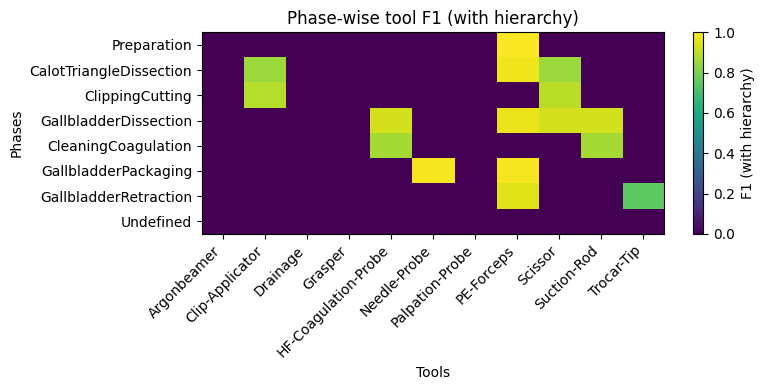

In [11]:
import numpy as np
from sklearn.metrics import f1_score

phase_ids = all_phase_targets.argmax(dim=-1).cpu().numpy()
tool_targets_np = all_tool_targets.cpu().numpy().astype(int)

probs_with = masked_logits.sigmoid().cpu().numpy()
preds_with = (probs_with >= 0.5).astype(int)

num_phases = len(PHASE_TO_ID)
num_tools = len(TOOL_COLUMNS)
phase_tool_f1 = np.zeros((num_phases, num_tools))

for p_idx, _ in enumerate(PHASE_TO_ID.keys()):
    mask = phase_ids == p_idx
    if mask.sum() == 0:
        continue
    for t_idx in range(num_tools):
        phase_tool_f1[p_idx, t_idx] = f1_score(
            tool_targets_np[mask, t_idx], preds_with[mask, t_idx], zero_division=0
        )

plt.figure(figsize=(8, 4))
plt.imshow(phase_tool_f1, aspect='auto', cmap='viridis', vmin=0.0, vmax=1.0)
plt.colorbar(label='F1 (with hierarchy)')
plt.yticks(range(num_phases), list(PHASE_TO_ID.keys()))
plt.xticks(range(num_tools), TOOL_COLUMNS, rotation=45, ha='right')
plt.xlabel('Tools')
plt.ylabel('Phases')
plt.title('Phase-wise tool F1 (with hierarchy)')
plt.tight_layout()
save_figure('phase_tool_f1_heatmap.png', EXPORT_DIR)
plt.show()

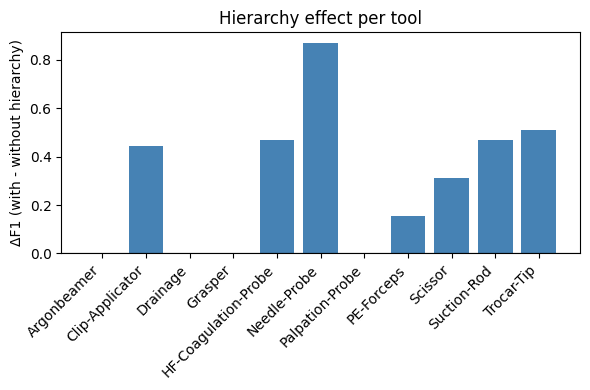

In [12]:
delta_values = tool_summary['delta_f1'].values
plt.figure(figsize=(6, 4))
plt.bar(tool_summary.index, delta_values, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('ΔF1 (with - without hierarchy)')
plt.title('Hierarchy effect per tool')
plt.axhline(0.0, color='black', linewidth=0.8)
plt.tight_layout()
save_figure('tool_delta_f1_bar.png', EXPORT_DIR)
plt.show()

Example 0: true=Preparation, pred=Preparation
  Top tools (unmasked):
    Scissor: 1.000
    Suction-Rod: 1.000
    HF-Coagulation-Probe: 1.000
    Clip-Applicator: 1.000
    Trocar-Tip: 1.000
  Top tools (masked):
    PE-Forceps: 1.000
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    Scissor: 0.000
    Palpation-Probe: 0.000



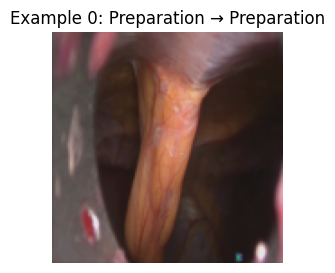

Example 1: true=Preparation, pred=Preparation
  Top tools (unmasked):
    Scissor: 1.000
    Suction-Rod: 1.000
    HF-Coagulation-Probe: 1.000
    Clip-Applicator: 1.000
    Trocar-Tip: 1.000
  Top tools (masked):
    PE-Forceps: 1.000
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    Scissor: 0.000
    Palpation-Probe: 0.000



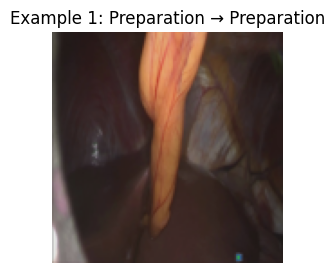

Example 2: true=Preparation, pred=Preparation
  Top tools (unmasked):
    Trocar-Tip: 1.000
    Suction-Rod: 1.000
    Scissor: 1.000
    PE-Forceps: 1.000
    Needle-Probe: 1.000
  Top tools (masked):
    PE-Forceps: 1.000
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    Scissor: 0.000
    Palpation-Probe: 0.000



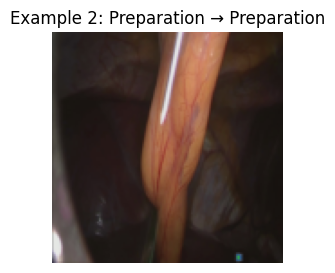

In [13]:
num_examples = 3
examples = []
for i in range(num_examples):
    frames, phase_target, tool_target = test_dataset[i]
    examples.append((frames.unsqueeze(0), phase_target, tool_target))

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

for idx, (frames, phase_target, tool_target) in enumerate(examples):
    with torch.no_grad():
        phase_logits, tool_logits = model(frames.to(DEVICE))
        phase_probs = phase_logits.softmax(dim=-1)
        tool_probs = tool_logits.sigmoid()
        masked_logits_ex = apply_phase_mask_to_logits(tool_logits, phase_probs, phase_tool_mask, hard=False)
        masked_probs = masked_logits_ex.sigmoid()
    true_phase_id = phase_target.argmax().item()
    pred_phase_id = phase_probs.argmax(dim=-1).item()
    print(f'Example {idx}: true={ID_TO_PHASE[true_phase_id]}, pred={ID_TO_PHASE[pred_phase_id]}')
    probs = tool_probs.squeeze(0).cpu().numpy()
    mprobs = masked_probs.squeeze(0).cpu().numpy()
    print('  Top tools (unmasked):')
    for i in probs.argsort()[::-1][:5]:
        print(f'    {TOOL_COLUMNS[i]}: {probs[i]:.3f}')
    print('  Top tools (masked):')
    for i in mprobs.argsort()[::-1][:5]:
        print(f'    {TOOL_COLUMNS[i]}: {mprobs[i]:.3f}')
    print()

    # Show the center frame for this example
    frames_unnorm = frames * std + mean
    center = frames_unnorm[0, frames_unnorm.shape[1] // 2]  # (C, H, W)
    img = center.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Example {idx}: {ID_TO_PHASE[true_phase_id]} → {ID_TO_PHASE[pred_phase_id]}')
    plt.show()

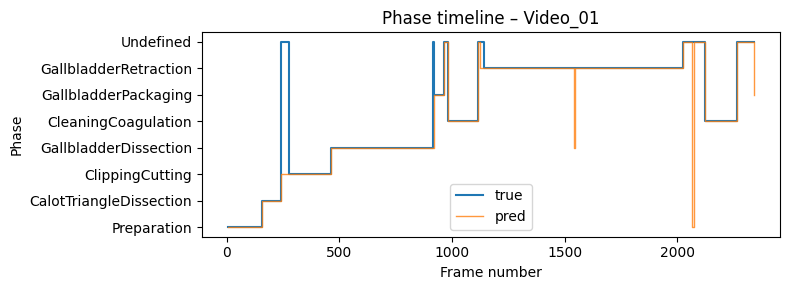

In [14]:
phase_true_ids = all_phase_targets.argmax(dim=-1).cpu().numpy()
phase_pred_ids = all_phase_logits.softmax(dim=-1).argmax(dim=-1).cpu().numpy()

videos = []
frame_numbers = []
for global_idx in test_dataset.valid_indices:
    row = test_dataset.samples[global_idx]
    videos.append(row['video'])
    frame_numbers.append(int(row['frame_number']))

videos = np.array(videos)
frame_numbers = np.array(frame_numbers)

unique_videos = np.unique(videos)
if len(unique_videos) > 0:
    vid = unique_videos[0]
    mask = videos == vid
    order = np.argsort(frame_numbers[mask])
    frames_v = frame_numbers[mask][order]
    true_v = phase_true_ids[mask][order]
    pred_v = phase_pred_ids[mask][order]

    plt.figure(figsize=(8, 3))
    plt.step(frames_v, true_v, where='post', label='true', linewidth=1.5)
    plt.step(frames_v, pred_v, where='post', label='pred', linewidth=1.0, alpha=0.8)
    plt.yticks(range(len(PHASE_TO_ID)), list(PHASE_TO_ID.keys()))
    plt.xlabel('Frame number')
    plt.ylabel('Phase')
    plt.title(f'Phase timeline – {vid}')
    plt.legend()
    plt.tight_layout()
    save_figure('phase_timeline_example.png', EXPORT_DIR)
    plt.show()